# Linear regression (omzet)

**imports & connection**

In [91]:
import pandas as pd
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [92]:
DB = {'servername': 'LAPTOP-LPE28RPE\SQLEXPRESS', 
    'database': 'United_outdoors'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                              ';DATABASE=' + DB['database'])

export_cursor = export_conn.cursor()
export_cursor   

**Database connection**

In [93]:

Adventure = {
    'servername' : 'LAPTOP-LPE28RPE\SQLEXPRESS',
    'database' : 'AdventureWorks2019'
}


Northwind = {
    'servername' : 'LAPTOP-LPE28RPE\SQLEXPRESS',
    'database' : 'Northwind'
}

access_db_path = r'C:\Users\Humberto de Castro\OneDrive\Desktop\SEM4\AenC\aenc.accdb'

#Connect to AdventureWorks
Adventure_conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={Adventure['servername']};DATABASE={Adventure['database']};Trusted_Connection=yes;")
Adventure_cursor = Adventure_conn.cursor()

#Connect to Northwind
Northwind_conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={Northwind['servername']};DATABASE={Northwind['database']};Trusted_Connection=yes;")
Northwind_cursor = Northwind_conn.cursor()

#Connect to AenC
AenC_conn = pyodbc.connect(f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={access_db_path};")



In [94]:
AdventureWorks_queries = {
    'SalesOrderHeader' : 'SELECT * FROM Sales.SalesOrderHeader',
    'SalesOrderDetail' : 'SELECT * FROM Sales.SalesOrderDetail'
}

Northwind_queries = {
    'Orders' : 'SELECT * FROM Orders',
    'OrderDetails' : 'SELECT * FROM [Order Details]'
}

AenC_queries = {
    'sales_order' : 'SELECT * FROM sales_order',
    'sales_order_item' : 'SELECT * FROM sales_order_item',
    'Product' : 'SELECT * FROM Product' 
}

dataframes = {}

# Lees elke tabel in een DataFrame

for table_name, query in AdventureWorks_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, Adventure_conn)

for table_name, query in Northwind_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, Northwind_conn)

for table_name, query in AenC_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, AenC_conn)

#als je ik elk tabel als een dataframe/ variabele wil behandelen of aanroepen moet ik dit uitvoeren.
for table_name, df in dataframes.items():
    globals()[table_name] = df


C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_34340\1319449748.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table_name] = pd.read_sql_query(query, Adventure_conn)
C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_34340\1319449748.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table_name] = pd.read_sql_query(query, Northwind_conn)
C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_34340\1319449748.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframes[table

### Order

**Extract**

In [95]:
#eerst horizontaal samenvoegen per database:
AdventureWorks_Order = pd.merge(SalesOrderHeader, SalesOrderDetail, on = 'SalesOrderID')
Northwind_Order = pd.merge(Orders, OrderDetails, on = 'OrderID')
merge1 = pd.merge(Product, sales_order_item, left_on= 'id', right_on= 'prod_id')
AenC_Order = pd.merge(merge1, sales_order, left_on = 'id_y', right_on = 'id')

print(AdventureWorks_Order.dtypes)

SalesOrderID                       int64
RevisionNumber                     int64
OrderDate                 datetime64[ns]
DueDate                   datetime64[ns]
ShipDate                  datetime64[ns]
Status                             int64
OnlineOrderFlag                     bool
SalesOrderNumber                  object
PurchaseOrderNumber               object
AccountNumber                     object
CustomerID                         int64
SalesPersonID                    float64
TerritoryID                        int64
BillToAddressID                    int64
ShipToAddressID                    int64
ShipMethodID                       int64
CreditCardID                     float64
CreditCardApprovalCode            object
CurrencyRateID                   float64
SubTotal                         float64
TaxAmt                           float64
Freight                          float64
TotalDue                         float64
Comment                           object
rowguid_x       

**Transform**

In [96]:
AdventureWorks_Order.rename(columns={
    'SalesOrderID': 'OrderID',
    'SalesOrderDetailID': 'OrderDetailID',
    'OrderQty': 'Quantity',
    'UnitPriceDiscount': 'Discount',
    'Order_Date': 'OrderDate',
    'SalesPersonID' : 'EmployeeID'
}, inplace=True)

# Vul NaN waarden in EmployeeID met een standaardwaarde (bijv. 0)
AdventureWorks_Order['EmployeeID'].fillna(0, inplace=True)

# change employe id type to int

AdventureWorks_Order['EmployeeID'] = AdventureWorks_Order['EmployeeID'].astype(int)

# change shipvia to string 
#Northwind_Order['ShipVia'] = Northwind_Order['ShipVia'].astype(str)
Northwind_Order.rename(columns={
    'ShipVia': 'ShipMethodID'
}, inplace=True)

AenC_Order.rename(columns={
    'id': 'OrderID',
    'item_id': 'OrderDetailID',
    'quantity_y': 'Quantity',
    'order_date': 'OrderDate',
    'unit_price': 'UnitPrice',
    'cust_id': 'CustomerID',
    'sales_rep': 'EmployeeID',
    'prod_id': 'ProductID'
}, inplace=True)

C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_34340\2543201151.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  AdventureWorks_Order['EmployeeID'].fillna(0, inplace=True)


**Check of orderID's conflicten**

In [97]:
order_order_ids = set(AdventureWorks_Order['OrderID'])
order_details_order_ids = set(Northwind_Order['OrderID'])
Order_AenC_ids = set(AenC_Order['OrderID'])

# Zoek conflicten tussen AdventureWorks en Northwind
conflicting_order_ids_1 = order_order_ids.intersection(order_details_order_ids)

# Zoek conflicten tussen AdventureWorks en AenC
conflicting_order_ids_2 = order_order_ids.intersection(Order_AenC_ids)

# Zoek conflicten tussen Northwind en AenC
conflicting_order_ids_3 = order_details_order_ids.intersection(Order_AenC_ids)

# Combineer alle conflicterende ID's
all_conflicting_order_ids = conflicting_order_ids_1.union(conflicting_order_ids_2).union(conflicting_order_ids_3)

if all_conflicting_order_ids:
    print("Conflicting Order IDs found:", all_conflicting_order_ids)
else:
    print("No conflicts found in Order IDs.")

# Display the conflicting Order IDs (if any)
conflicts_df = pd.DataFrame(list(all_conflicting_order_ids), columns=['Conflicting Order IDs'])
print(conflicts_df)

No conflicts found in Order IDs.
Empty DataFrame
Columns: [Conflicting Order IDs]
Index: []


**Alle dubbele ID's met een suffix zetten per database**

In [98]:


# Prefixes toevoegen
AdventureWorks_Order['EmployeeID'] = AdventureWorks_Order['EmployeeID'].apply(lambda x: f'AW_{x}')
Northwind_Order['EmployeeID'] = Northwind_Order['EmployeeID'].apply(lambda x: f'NW_{x}')
AenC_Order['EmployeeID'] = AenC_Order['EmployeeID'].apply(lambda x: f'AC_{x}')

# Vervang 'AW_0' met 'NULL' in de kolom EmployeeID
AdventureWorks_Order['EmployeeID'] = AdventureWorks_Order['EmployeeID'].replace('AW_0', None)

AdventureWorks_Order['ShipMethodID'] = AdventureWorks_Order['ShipMethodID'].apply(lambda x: f'AW_{x}')
Northwind_Order['ShipMethodID'] = Northwind_Order['ShipMethodID'].apply(lambda x: f'NW_{x}')
# AenC_Order heeft geen ShipMethodID

AdventureWorks_Order['ProductID'] = AdventureWorks_Order['ProductID'].apply(lambda x: f'AW_{x}')
Northwind_Order['ProductID'] = Northwind_Order['ProductID'].apply(lambda x: f'NW_{x}')
AenC_Order['ProductID'] = AenC_Order['ProductID'].apply(lambda x: f'AC_{x}')

AdventureWorks_Order['CustomerID'] = AdventureWorks_Order['CustomerID'].apply(lambda x: f'AW_{x}')
Northwind_Order['CustomerID'] = Northwind_Order['CustomerID'].apply(lambda x: f'NW_{x}')
AenC_Order['CustomerID'] = AenC_Order['CustomerID'].apply(lambda x: f'AC_{x}')

In [99]:




# Zorg ervoor dat alle vereiste kolommen bestaan en selecteer ze
required_columns = ['OrderID', 'OrderDetailID', 'Quantity', 'UnitPrice', 'Discount', 'OrderDate', 'CustomerID', 'EmployeeID', 'ShipMethodID', 'ProductID']

for col in required_columns:
    if col not in AdventureWorks_Order.columns:
        AdventureWorks_Order[col] = None
    if col not in Northwind_Order.columns:
        Northwind_Order[col] = None
    if col not in AenC_Order.columns:
        AenC_Order[col] = None

# Selecteer de kolommen in de juiste volgorde
AdventureWorks_Order = AdventureWorks_Order[required_columns]
Northwind_Order = Northwind_Order[required_columns]
AenC_Order = AenC_Order[required_columns]

# Combineer de dataframes
Order = pd.concat([AdventureWorks_Order, Northwind_Order, AenC_Order], ignore_index=True)

# Converteer 'Quantity' en 'UnitPrice' naar numerieke typen
Order['Quantity'] = pd.to_numeric(Order['Quantity'], errors='coerce')
Order['UnitPrice'] = pd.to_numeric(Order['UnitPrice'], errors='coerce')

Order['Omzet'] = Order['UnitPrice'] * Order['Quantity']

Temporder = Order

# Toon het resultaat
#print(combined_df)
print(Order.dtypes)

C:\Users\Humberto de Castro\AppData\Local\Temp\ipykernel_34340\2715897028.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Order = pd.concat([AdventureWorks_Order, Northwind_Order, AenC_Order], ignore_index=True)


OrderID           object
OrderDetailID     object
Quantity           int64
UnitPrice        float64
Discount         float64
OrderDate         object
CustomerID        object
EmployeeID        object
ShipMethodID      object
ProductID         object
Omzet            float64
dtype: object


## Begin met machine learning

**Kolomen selecteren**

In [100]:

Order = Order.loc[:, ['Quantity', 'UnitPrice', 'OrderDate', 'ProductID', 'Omzet']]
# Correctie: Zet ORDER_DATE om naar datetime-formaat
Order['OrderDate'] = pd.to_datetime(Order['OrderDate'], errors='coerce')

### **One-hot encoding van onafhankelijke kolommen niet-numerieke variabelen**

In [101]:

Order['OrderYear'] = Order['OrderDate'].dt.year
Order['OrderMonth'] = Order['OrderDate'].dt.month
Order['OrderDay'] = Order['OrderDate'].dt.day

# Create dummy variables for 'OrderYear', 'OrderMonth', and 'OrderDay'
year_dummies = pd.get_dummies(Order['OrderYear'], prefix='Year')
month_dummies = pd.get_dummies(Order['OrderMonth'], prefix='Month')
day_dummies = pd.get_dummies(Order['OrderDay'], prefix='Day')
Product_dummies = pd.get_dummies(Order['ProductID'], prefix='Product')


In [102]:
# Voeg een nieuwe kolom toe met de orders plus één jaar
Order['OrderYear_plus_one'] = Order['OrderYear'] + 1

# Concatenate the dummy variables with the original DataFrame
Order = pd.concat([Order, year_dummies, month_dummies, day_dummies, Product_dummies], axis=1)

# Drop de oorspronkelijke kolommen
Order.drop(['OrderYear', 'OrderMonth', 'OrderDay', 'ProductID'], axis=1, inplace=True)

# Display the first few rows of the updated DataFrame
print(Order.head())


   Quantity  UnitPrice  OrderDate     Omzet  OrderYear_plus_one  Year_1996  \
0         1   2024.994 2011-05-31  2024.994                2012      False   
1         3   2024.994 2011-05-31  6074.982                2012      False   
2         1   2024.994 2011-05-31  2024.994                2012      False   
3         1   2039.994 2011-05-31  2039.994                2012      False   
4         1   2039.994 2011-05-31  2039.994                2012      False   

   Year_1997  Year_1998  Year_1999  Year_2011  ...  Product_NW_70  \
0      False      False      False       True  ...          False   
1      False      False      False       True  ...          False   
2      False      False      False       True  ...          False   
3      False      False      False       True  ...          False   
4      False      False      False       True  ...          False   

   Product_NW_71  Product_NW_72  Product_NW_73  Product_NW_74  Product_NW_75  \
0          False          False     

## **horizontaal en Verticaal snijden**

In [103]:
# Splits de data in train en test sets, behoud OrderID
x = Order.drop(['Omzet', 'OrderYear_plus_one', 'OrderDate'], axis=1)
y = Order['Omzet']


x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size = 0.15,
    random_state = 42
)
y_test

79274     1700.9900
115505    2384.0700
46155        4.9900
3733        60.5595
109270      53.9900
            ...    
115749      29.9900
84838       69.9900
105873       3.9900
12977      269.9640
93760     2384.0700
Name: Omzet, Length: 18687, dtype: float64

## **Regressiemodel bouwen**

**Training model**

In [104]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train, y_train)
reg_model

LinearRegression()

**Prediction met x_test**

In [105]:
y_pred = reg_model.predict(x_test)

prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns = {0: 'Predicted_omzet'})
prediction_df

,Predicted_omzet
0,1882.858795
1,2185.640839
2,0.142975
3,-128.852356
4,-175.537384
...,...
18682,118.635712
18683,-175.880219
18684,-90.837860
18685,322.798645


**Prediction vergelijken met y_test**

In [106]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['Omzet'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['Predicted_omzet'].notna(), :]


,Omzet,Predicted_omzet
0,1700.9900,1882.858795
1,2384.0700,2185.640839
2,4.9900,0.142975
3,60.5595,-128.852356
4,53.9900,-175.537384
...,...,...
18682,29.9900,118.635712
18683,69.9900,-175.880219
18684,3.9900,-90.837860
18685,269.9640,322.798645


In [107]:
#print(Temporder.columns)

Index(['OrderID', 'OrderDetailID', 'Quantity', 'UnitPrice', 'Discount',
       'OrderDate', 'CustomerID', 'EmployeeID', 'ShipMethodID', 'ProductID',
       'Omzet'],
      dtype='object')


In [115]:
#Temporder_unique = Temporder[['Omzet', 'OrderDate']].drop_duplicates()


In [116]:
# Merge de voorspellingen met de Order-tabel om OrderDate toe te voegen
#merged_df = y_test_prediction_merge.merge(Temporder[['Omzet', 'OrderDate']], on='Omzet', how='left')


In [119]:
#merged_df 

,Omzet,Predicted_omzet,OrderDate
0,1700.99,1882.858795,2013-05-30 00:00:00
1,1700.99,1882.858795,2013-05-30 00:00:00
2,1700.99,1882.858795,2013-05-31 00:00:00
3,1700.99,1882.858795,2013-06-02 00:00:00
4,1700.99,1882.858795,2013-06-02 00:00:00
...,...,...,...
31540550,2384.07,2114.830475,2014-05-29 00:00:00
31540551,2384.07,2114.830475,2014-05-29 00:00:00
31540552,2384.07,2114.830475,2014-05-29 00:00:00
31540553,2384.07,2114.830475,2014-05-30 00:00:00


**Scatterplot**

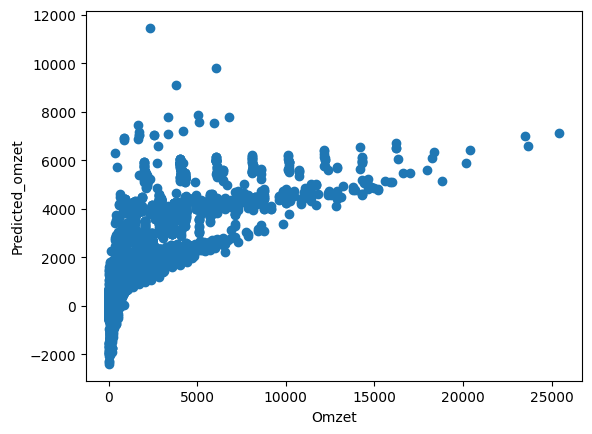

In [110]:
plt.scatter(y_test_prediction_merge['Omzet'], y_test_prediction_merge['Predicted_omzet'])
plt.xlabel('Omzet')
plt.ylabel('Predicted_omzet')
plt.show()

## **Regressie uitkomst**

**Mean Squared Error (MSE)**
\
-kwadrateer elke errorgrootte
\
-Bereken het gemiddelde van alle kwadraten

In [111]:
mean_squared_error(y_test_prediction_merge['Omzet'], y_test_prediction_merge['Predicted_omzet'])

968873.80234751

**Mean Absolute Error (MAE)**
\
-verander elke min-errorgrootte in een plus errorgrootte
\
-Bereken het gemiddelde van alle errorgroottes

In [112]:
mean_absolute_error(y_test_prediction_merge['Omzet'],y_test_prediction_merge['Predicted_omzet'])

403.79929769282603

# Data Loaden

In [120]:
# Insert data into the PredictedOmzet table
for index, row in y_test_prediction_merge.iterrows():
    try:
        query = """
        INSERT INTO PredictedOmzet (Omzet, Predicted_omzet)
        VALUES (?, ?)
        """
        params = (
            float(row['Omzet']) if pd.notnull(row['Omzet']) else None,
            float(row['Predicted_omzet']) if pd.notnull(row['Predicted_omzet']) else None,
        )
        export_cursor.execute(query, params)
    except pyodbc.Error as e:
        print(f"An error occurred: {e}")
        print(query)
        print("Parameters:", params)

export_conn.commit()

KeyboardInterrupt: 